# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [175]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
from pprint import pprint
from config import weather_api_key, gkey
from citipy import citipy
from datetime import datetime
import os
import csv

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [176]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

639

In [71]:
# To make the DataFrame look cleaner, convert the cities list to titlecase and no
cities_list = []
for city in cities: 
    cities_list.append(city.title())
    
len(cities_list)

579

In [78]:
# Create the Empty DataFrame for the API Calls: Columns == Temperature, Humidity, Cloudiness, Windspeed

cities_df = pd.DataFrame(cities_list)
cities_df = cities_df.rename(columns={0: "City"})
cities_df["Lat"] = ""
cities_df["Lng"] = ""
cities_df["Date and Time"] = ""
cities_df["Max Temperature"] = ""
cities_df["Humidity"] = ""
cities_df["Cloudiness"] = ""
cities_df["Windspeed"] = ""
cities_df

,City,Lat,Lng,Date and Time,Max Temperature,Humidity,Cloudiness,Windspeed
0,Kapaa,,,,,,,
1,Cheuskiny,,,,,,,
2,Belmonte,,,,,,,
3,Port Elizabeth,,,,,,,
4,Norman Wells,,,,,,,
...,...,...,...,...,...,...,...,...
574,Samusu,,,,,,,
575,Jubayl,,,,,,,
576,Leshukonskoye,,,,,,,
577,Bonavista,,,,,,,


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [79]:
# # Test DataFrame and API Calls

# # This is the test code I used to limit my API calls while troubleshooting 

# base_weather_url = "http://api.openweathermap.org/data/2.5/weather?q="

# # test city
# city_test = ["Punta Arenas"]
# cities_test_df = pd.DataFrame(city_test)
# cities_test_df = cities_test_df.rename(columns={0: "City"})
# cities_test_df["Max Temperature"] = ""
# cities_test_df["Humidity"] = ""
# cities_test_df["Cloudiness"] = ""
# cities_test_df["Windspeed"] = ""
# cities_test_df

# for index, row in cities_test_df.iterrows():
#     time.sleep(1)
#     city = row["City"]
#     get_weather_url = base_weather_url + f"{city}&appid={weather_api_key}&units=imperial"
#     weather_request = requests.get(get_weather_url).json()
#     date_time = weather_request["dt"]
#     date_time_converted = (datetime.utcfromtimestamp(date_time).strftime('%Y-%m-%d %H:%M:%S'))
#     temp = weather_request["main"]["temp_max"]
#     humid = weather_request["main"]["humidity"]
#     cloud = weather_request["clouds"]["all"]
#     wind = weather_request["wind"]["speed"]
#     lat = weather_request["coord"]["lat"]
#     lng = weather_request["coord"]["lon"]
#     pprint(weather_request)
    
#     cities_test_df.loc[index, "Date and Time"] = date_time_converted
#     cities_test_df.loc[index, "Lat"] = lat
#     cities_test_df.loc[index, "Lng"] = lng
#     cities_test_df.loc[index, "Max Temperature"] = temp
#     cities_test_df.loc[index, "Humidity"] = humid
#     cities_test_df.loc[index, "Cloudiness"] = cloud
#     cities_test_df.loc[index, "Windspeed"] = wind
# cities_test_df

In [80]:
# Set the base ULR Get: Temperature, Humidity, Cloudiness, Windspeed
base_weather_url = "http://api.openweathermap.org/data/2.5/weather?q="

# Display empty DataFrame, just as a reminder
cities_df

,City,Lat,Lng,Date and Time,Max Temperature,Humidity,Cloudiness,Windspeed
0,Kapaa,,,,,,,
1,Cheuskiny,,,,,,,
2,Belmonte,,,,,,,
3,Port Elizabeth,,,,,,,
4,Norman Wells,,,,,,,
...,...,...,...,...,...,...,...,...
574,Samusu,,,,,,,
575,Jubayl,,,,,,,
576,Leshukonskoye,,,,,,,
577,Bonavista,,,,,,,


In [81]:
#  for index, row in cities_pd.iterrows():

for index, row in cities_df.iterrows():
    time.sleep(1)
    city = row["City"]
    get_weather_url = base_weather_url + f"{city}&appid={weather_api_key}&units=imperial"
    weather_request = requests.get(get_weather_url).json()
    try:
        date_time = weather_request["dt"]
        date_time_converted = (datetime.utcfromtimestamp(date_time).strftime('%Y-%m-%d %H:%M:%S'))
        temp = weather_request["main"]["temp_max"]
        humid = weather_request["main"]["humidity"]
        cloud = weather_request["clouds"]["all"]
        wind = weather_request["wind"]["speed"]
        lat = weather_request["coord"]["lat"]
        lng = weather_request["coord"]["lon"]
        print(f"{city} success.")
    except KeyError:
        print(f"Data not found for {city}.")
        pass
    
    cities_df.loc[index, "Date and Time"] = date_time_converted    
    cities_df.loc[index, "Lat"] = lat
    cities_df.loc[index, "Lng"] = lng    
    cities_df.loc[index, "Max Temperature"] = temp
    cities_df.loc[index, "Humidity"] = humid
    cities_df.loc[index, "Cloudiness"] = cloud
    cities_df.loc[index, "Windspeed"] = wind

Kapaa success.
Data not found for Cheuskiny.
Belmonte success.
Port Elizabeth success.
Norman Wells success.
Bluff success.
Hovd success.
Hilo success.
Grindavik success.
Westport success.
Guanica success.
Albany success.
Ushuaia success.
Kaitangata success.
Jamestown success.
Longyearbyen success.
Ulladulla success.
Ilulissat success.
Tigre success.
Kozluk success.
Cockburn Town success.
Namibe success.
Severo-Kurilsk success.
Ejido success.
Port Alfred success.
Data not found for Belushya Guba.
Butaritari success.
Data not found for Warqla.
Thinadhoo success.
Chuy success.
Mbandaka success.
Reconquista success.
Atar success.
Aksarka success.
Rikitea success.
Torbay success.
Busselton success.
Data not found for Nizhneyansk.
Port Blair success.
Lebu success.
Krasnoselkup success.
Bethel success.
Roma success.
Cidreira success.
Okhotsk success.
Hobyo success.
Guangyuan success.
Port Shepstone success.
Berbera success.
Atuona success.
Virginia Beach success.
Hermanus success.
Biltine su

Vostochnyy success.
Manati success.
Caravelas success.
Constitucion success.
Manggar success.
Telhara success.
Melioratorov success.
Data not found for Macaboboni.
Berlevag success.
Saint Anthony success.
Bathsheba success.
Coquimbo success.
Nyurba success.
Umm Lajj success.
Honiara success.
Bosaso success.
Timbiqui success.
Kahului success.
Mehamn success.
Van success.
Gusau success.
Aras success.
Data not found for One Hundred Mile House.
Fukue success.
Oktyabrsk success.
Xinzhou success.
Buarcos success.
Guerrero Negro success.
Margate success.
Alice Springs success.
Marsh Harbour success.
Cheremukhovo success.
Kiunga success.
Nanortalik success.
Hambantota success.
Camacupa success.
Bay Roberts success.
Suez success.
Pemangkat success.
Svobodnyy success.
Baykit success.
Malyye Derbety success.
Bandarbeyla success.
Hay River success.
Neryungri success.
Polyarnyy success.
Sao Paulo De Olivenca success.
Petropavlovsk-Kamchatskiy success.
Namatanai success.
Data not found for Saryshaga

In [177]:
cities_df

,City,Lat,Lng,Date and Time,Max Temperature,Humidity,Cloudiness,Windspeed
0,Kapaa,22.08,-159.32,2020-10-20 16:55:17,73,79,46,8.55
1,Cheuskiny,22.08,-159.32,2020-10-20 16:55:17,73,79,46,8.55
2,Belmonte,-15.86,-38.88,2020-10-20 16:55:26,77,83,90,6.93
3,Port Elizabeth,-33.92,25.57,2020-10-20 16:53:30,62.6,72,10,19.46
4,Norman Wells,65.28,-126.83,2020-10-20 16:55:32,17.6,92,75,9.17
...,...,...,...,...,...,...,...,...
574,Samusu,-16.23,39.91,2020-10-20 17:08:12,78.96,72,0,10.94
575,Jubayl,-16.23,39.91,2020-10-20 17:08:12,78.96,72,0,10.94
576,Leshukonskoye,64.9,45.76,2020-10-20 17:01:03,25.41,98,88,6.13
577,Bonavista,48.65,-53.11,2020-10-20 17:03:17,55.24,81,99,14.27


### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [178]:
cities_df.to_csv("../output_data/api-data.csv")

In [179]:
csv_path = os.path.join("..", "output_data", "api-data.csv")
weather_df = pd.read_csv(csv_path)
weather_df = weather_df.drop(columns="Unnamed: 0")
weather_df

,City,Lat,Lng,Date and Time,Max Temperature,Humidity,Cloudiness,Windspeed
0,Kapaa,22.08,-159.32,2020-10-20 16:55:17,73.00,79,46,8.55
1,Cheuskiny,22.08,-159.32,2020-10-20 16:55:17,73.00,79,46,8.55
2,Belmonte,-15.86,-38.88,2020-10-20 16:55:26,77.00,83,90,6.93
3,Port Elizabeth,-33.92,25.57,2020-10-20 16:53:30,62.60,72,10,19.46
4,Norman Wells,65.28,-126.83,2020-10-20 16:55:32,17.60,92,75,9.17
...,...,...,...,...,...,...,...,...
574,Samusu,-16.23,39.91,2020-10-20 17:08:12,78.96,72,0,10.94
575,Jubayl,-16.23,39.91,2020-10-20 17:08:12,78.96,72,0,10.94
576,Leshukonskoye,64.90,45.76,2020-10-20 17:01:03,25.41,98,88,6.13
577,Bonavista,48.65,-53.11,2020-10-20 17:03:17,55.24,81,99,14.27


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [180]:
# Check to see if any cities have a humidity over 100%
gt100_humid = weather_df.loc[weather_df["Humidity"] > 100].count()
gt100_humid

City               0
Lat                0
Lng                0
Date and Time      0
Max Temperature    0
Humidity           0
Cloudiness         0
Windspeed          0
dtype: int64

In [181]:
#  No humidities over 100%.

## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

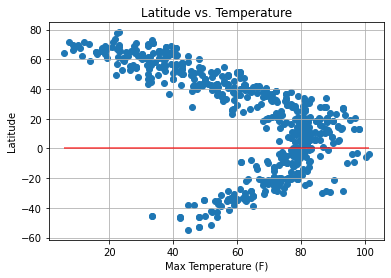

In [182]:
# Find and set the data to work with: Latitude and Max Temperature
lat_scatter = weather_df["Lat"]
temp_scatter = weather_df["Max Temperature"]

# Set the Labels for the Title, X-Axis, and Y-Axis
plt.ylabel("Latitude")
plt.xlabel("Max Temperature (F)")
plt.title("Latitude vs. Temperature")

# Add horizontal line for the "equator" and a grid to make it easier to read
plt.hlines(0, min(temp_scatter), max(temp_scatter), alpha=.75, color="red")
plt.grid()

# Populate and save the figure / plot
plt.scatter(temp_scatter, lat_scatter)
plt.savefig("../output_data/lat_vs_temp_fig1.jpeg")

### About Latitude vs. Temperature Scatter Plot

The above plot looks at the Max Temperature as taken on the date the data was pulled from the OpenWeather API: Date, 10-20-2020. Along with the Max Temperature is the latitude of each city in the `weather_df` dataframe. 

Instead of latitude being on the x-axis, I put it on the y-axis to make a more recognizable vizualization via a scatter plot. One can now look at this as though it were a two-dimensional globe. "0" on the y-axis is now where the equater is (represented by the red horizontal line).

The scatter plot was used since there were multiple data points that were not categorical (ruling out bar/pie) and the data were not a time-series (since they were pulled at a specific point in time rather than over several points in time). 

#### Observations
* As the temperature increases, the points move closer to the equator (i.e., Lat = 0)

## Latitude vs. Humidity Plot

## Latitude vs. Cloudiness Plot

## Latitude vs. Wind Speed Plot

## Linear Regression

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression